In [1]:
#packages
!pip install xgboost
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

from scipy import interp
from itertools import cycle
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import seaborn as sns

import joblib

In [2]:
#data import
df = pd.read_csv('/Users/zhanghanni/Desktop/Habitat Prediction/J_locations_grouped_sorted_v10 - J_locations_grouped_sorted-2.csv')

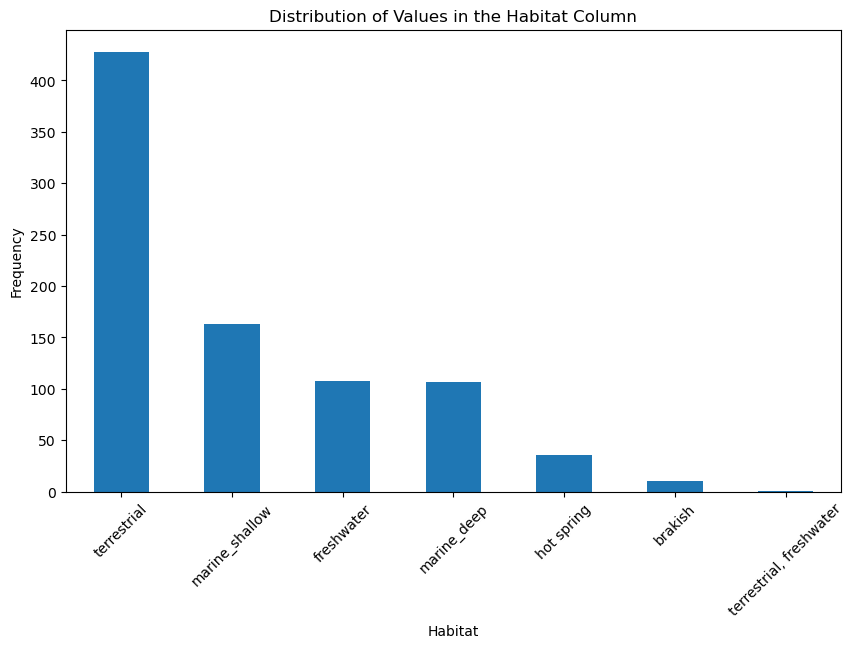

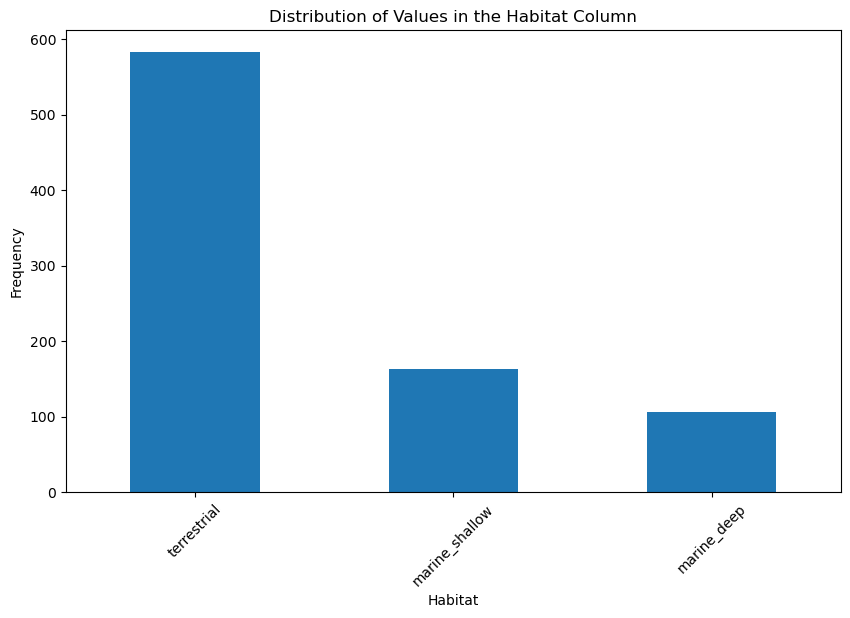

Index(['ncbi_isolate_source', 'location', 'GOLD ORGANISM HABITAT',
       'GOLD ORGANISM SAMPLE COLLECTION SITE',
       'GOLD ORGANISM ECOSYSTEM CATEGORY', 'GOLD ORGANISM ECOSYSTEM TYPE',
       'GOLD ORGANISM ECOSYSTEM SUBTYPE', 'GOLD ORGANISM SPECIFIC ECOSYSTEM',
       'GOLD ORGANISM ISOLATION HOST NAME', 'habitat_grouped'],
      dtype='object')


In [3]:
#EDA
# 1. Plotting the distribution of values in the 'habitat' column
plt.figure(figsize=(10, 6))
df['habitat'].value_counts().plot(kind='bar')
plt.title('Distribution of Values in the Habitat Column')
plt.xlabel('Habitat')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 2. group the habitat
# Define a mapping for the habitat groups
habitat_group_mapping = {
    "terrestrial": ["terrestrial", "freshwater", "hot spring", "brakish", "terrestrial, freshwater"],
    "marine_shallow": ["marine_shallow"],
    "marine_deep": ["marine_deep"],
}
# Function to assign habitat group based on habitat
def assign_habitat_group(habitat):
    for group, habitats in habitat_group_mapping.items():
        if habitat in habitats:
            return group
    return "other"  # default group if no match found

# Apply the function to create 'habitat_grouped' column
df['habitat_grouped'] = df['habitat'].apply(assign_habitat_group)
plt.figure(figsize=(10, 6))
df['habitat_grouped'].value_counts().plot(kind='bar')
plt.title('Distribution of Values in the Habitat Column')
plt.xlabel('Habitat')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

df = df.drop('habitat', axis=1)

df.head()
print(df.columns)

In [4]:


# Function to preprocess text
def preprocess_text(text):
    # Check if the text is NaN or None
    if (pd.isna(text)) or (text is None) or (text.lower() in ['none', 'unclassified']):
        return 'missing'  # Use a placeholder for missing values
    # Keep digits and letters, remove other characters
    text = re.sub("[^a-zA-Z0-9\s]", " ", str(text))
    # Convert to lowercase
    return text.lower()

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=None)  # Adjust the number of features as needed

# Columns to exclude from TF-IDF processing
excluded_columns = ['habitat', 'habitat_grouped']

# Concatenate all text data into a single column for TF-IDF processing
combined_text = df[df.columns.difference(excluded_columns)].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Apply text preprocessing
combined_text = combined_text.apply(preprocess_text)

# Fit and transform with TF-IDF
tfidf_features = tfidf_vectorizer.fit_transform(combined_text)

# Save the fitted vectorizer and feature names for deployment
joblib.dump(tfidf_vectorizer, 'TRAIN_tfidf_vectorizer.joblib')

# Create DataFrame from TF-IDF features
tfidf_features_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Optionally, save the DataFrame to a CSV file
tfidf_features_df.to_csv("TRAIN_tfidf_features_df.csv", index=False)

print(len(tfidf_features_df.columns))


3801


In [7]:
#Optimized: XGBoost hyperparameter tuning
# XGBoost hyperparameter tuning
X = tfidf_features_df
y = df['habitat_grouped']

# Encoding string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the parameter distribution for RandomizedSearch
param_dist = {
    'max_depth': [8, 10, 12],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'n_estimators': [200, 400, 600],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Stratified K-Fold for balanced class distribution in cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, scoring='accuracy', cv=stratified_kfold, verbose=2, random_state=42)
random_search.fit(X, y_encoded)

# Get the best parameters and accuracy score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Output best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.9, learning_rate=0.030000000000000006, max_depth=10, n_estimators=400, subsample=0.8; total time=   6.9s
[CV] END colsample_bytree=0.9, learning_rate=0.030000000000000006, max_depth=10, n_estimators=400, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.9, learning_rate=0.030000000000000006, max_depth=10, n_estimators=400, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.8, learning_rate=0.030000000000000006, max_depth=10, n_estimators=200, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.030000000000000006, max_depth=10, n_estimators=200, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=0.030000000000000006, max_depth=10, n_estimators=200, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.9, learning_rate=0.06000000000000001, max_depth=12, n_estimators=400, subsample=0.9; total time=   6.8s
[CV] END 

In [17]:
#optimzed: refined search based on prev

# XGBoost hyperparameter tuning
X = tfidf_features_df
y = df['habitat_grouped']

# Encoding string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define a more refined parameter grid around the best parameters found
refined_param_grid = {
    'max_depth': [4,5,6],  # One above and below the best value
    'learning_rate': [0.01],  # Smaller steps around the best value
    'n_estimators': [350],  # Smaller steps around the best value
    'subsample': [0.7, 0.6,0.5],  # Smaller steps around the best value
    'colsample_bytree': [0.6, 0.7,0.5]  # Smaller steps around the best value
}

#Refined Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 350, 'subsample': 0.8}
#Refined Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 350, 'subsample': 0.7}
#Refined Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 350, 'subsample': 0.7}

#best_params = {"max_depth": 9, "learning_rate": 0.01, "n_estimators": 600, "subsample": 0.8, "colsample_bytree": 0.8}
#best as of Jan 19 search-without SRA column



# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Stratified K-Fold for balanced class distribution in cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV for refined search
refined_search = GridSearchCV(xgb_model, param_grid=refined_param_grid, scoring='accuracy', cv=stratified_kfold, verbose=2)
refined_search.fit(X, y_encoded)

# Get the best parameters and accuracy score
refined_best_params = refined_search.best_params_
refined_best_score = refined_search.best_score_

# Output best parameters and best score
print("Refined Best Parameters:", refined_best_params)
print("Refined Best Accuracy Score:", refined_best_score)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.7; total time=   4.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.7; total time=   4.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=4, n_estimators=350, subsample=0.6; total time=   4.4s
[CV] END c

In [6]:
#Unoptimzed: XGBoost hyperparameter tuning
X = tfidf_features_df
y = df['habitat_grouped']

# Encoding string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the parameter distribution for RandomizedSearch
param_grid = {
    'max_depth': [8,9,10,11],
    'learning_rate': [0.01],
    'n_estimators': [ 200, 300, 400, 500,600,700, 800],
    #'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}



# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Stratified K-Fold for balanced class distribution in cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup RandomizedSearchCV
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold, verbose=2)
grid_search.fit(X, y_encoded)

# Get the best parameters and accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Output best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_score)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.8; total time=   5.7s
[CV] END c

KeyboardInterrupt: 

In [30]:
#XGBoost final model
X = tfidf_features_df
y = df['habitat_grouped']

# Encoding string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Binarize the output for ROC curve
y_binarized = label_binarize(y_encoded, classes=range(num_classes))

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test, y_train_binarized, y_test_binarized = train_test_split(X, y_encoded, y_binarized, test_size=0.05, random_state=42)

# Initialize XGBoost classifier with the best parameters
#best_params = {"max_depth": 8, "learning_rate": 0.01, "n_estimators": 300, "subsample": 0.8, "colsample_bytree": 0.8}
#best as of Jan 19 search-with SRA column
#best_params = {"max_depth": 9, "learning_rate": 0.01, "n_estimators": 600, "subsample": 0.8, "colsample_bytree": 0.8}
#best as of Jan 19 search-without SRA column

#Best Parameters: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.04000000000000001, 'colsample_bytree': 0.8
#Refined Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 350, 'subsample': 0.8}
#best as of no limit on num columns for training   
#Refined Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 350, 'subsample': 0.7}

best_params = {"max_depth": 6, "learning_rate": 0.01, "n_estimators": 350, "subsample": 0.7, "colsample_bytree": 0.7}
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)
   
for original_label, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"Original Label: {original_label} - Encoded Label: {encoded_label}")



F1 Score: 0.9534883720930233
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      0.83      0.83         6
           2       0.97      0.97      0.97        32

    accuracy                           0.95        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.95      0.95      0.95        43

Original Label: marine_deep - Encoded Label: 0
Original Label: marine_shallow - Encoded Label: 1
Original Label: terrestrial - Encoded Label: 2


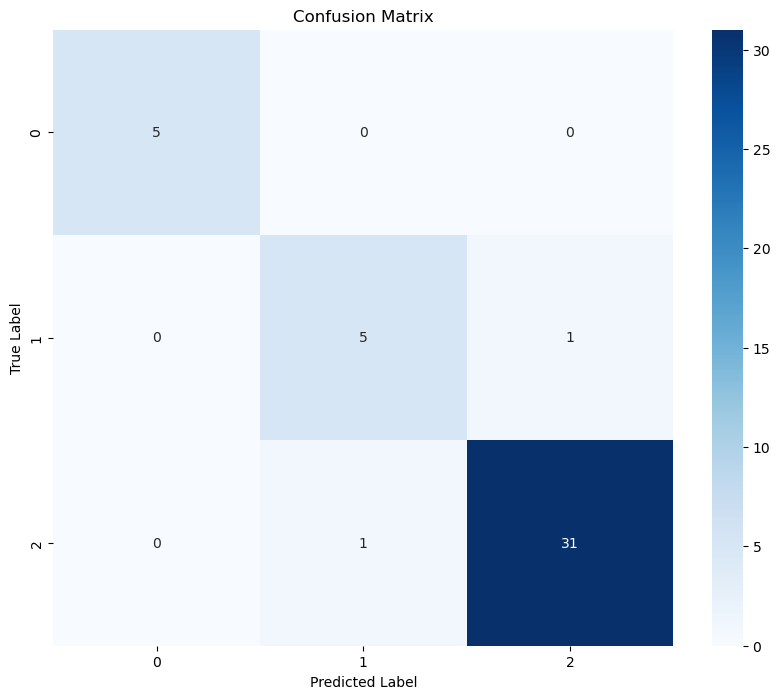

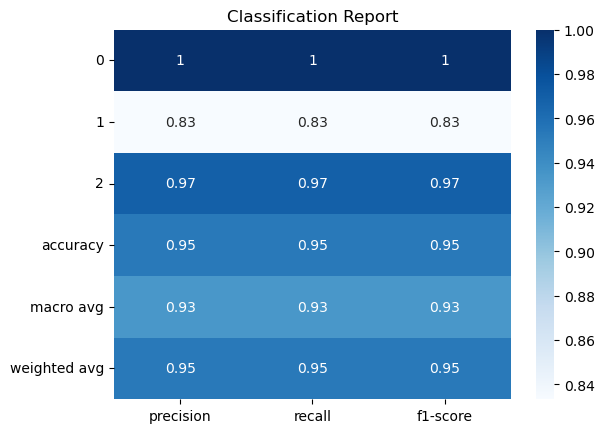

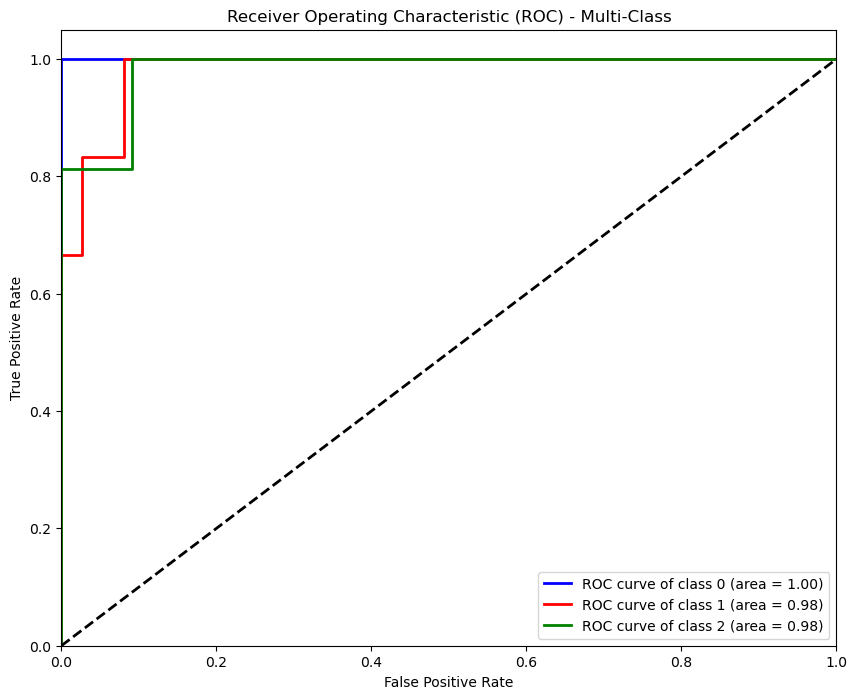

In [22]:
#visulizaiton
# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report Visualization
report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

# ROC Curve for Multiclass Classification
# Binarize the output labels for multiclass
y_test_binarized = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], xgb_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

# Plotting
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [23]:
print(len(tfidf_features_df.columns))
#process atributes for prediction
selected_columns = ['ncbi_isolate_source', 'location', 'GOLD ORGANISM HABITAT',
                    'GOLD ORGANISM SAMPLE COLLECTION SITE', 'GOLD ORGANISM ECOSYSTEM CATEGORY',
                    'GOLD ORGANISM ECOSYSTEM TYPE', 'GOLD ORGANISM ECOSYSTEM SUBTYPE',
                    'GOLD ORGANISM SPECIFIC ECOSYSTEM', 'GOLD ORGANISM ISOLATION HOST NAME']
# Load the CSV file for prediction
csv_file_path = '/Users/zhanghanni/Desktop/Habitat Prediction/H_locations_grouped_sorted.csv'
attr = pd.read_csv(csv_file_path)
attr = attr[selected_columns]
print(attr.columns)
print(df.columns)
print(len(attr.columns))
print(len(df.columns))
print(tfidf_features_train.columns)

3801
Index(['ncbi_isolate_source', 'location', 'GOLD ORGANISM HABITAT',
       'GOLD ORGANISM SAMPLE COLLECTION SITE',
       'GOLD ORGANISM ECOSYSTEM CATEGORY', 'GOLD ORGANISM ECOSYSTEM TYPE',
       'GOLD ORGANISM ECOSYSTEM SUBTYPE', 'GOLD ORGANISM SPECIFIC ECOSYSTEM',
       'GOLD ORGANISM ISOLATION HOST NAME'],
      dtype='object')
Index(['ncbi_isolate_source', 'location', 'GOLD ORGANISM HABITAT',
       'GOLD ORGANISM SAMPLE COLLECTION SITE',
       'GOLD ORGANISM ECOSYSTEM CATEGORY', 'GOLD ORGANISM ECOSYSTEM TYPE',
       'GOLD ORGANISM ECOSYSTEM SUBTYPE', 'GOLD ORGANISM SPECIFIC ECOSYSTEM',
       'GOLD ORGANISM ISOLATION HOST NAME', 'habitat_grouped'],
      dtype='object')
9
10


NameError: name 'tfidf_features_train' is not defined

In [31]:
# Load the trained TF-IDF Vectorizer
tfidf_vectorizer = joblib.load('TRAIN_tfidf_vectorizer.joblib')


# Columns to exclude from TF-IDF processing
excluded_columns = ['habitat', 'habitat_grouped']

# Concatenate all text data into a single column for TF-IDF processing
combined_text_pred = attr[attr.columns.difference(excluded_columns)].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Apply text preprocessing
combined_text_pred = combined_text_pred.apply(preprocess_text)

# Transform the prediction data using the loaded vectorizer
tfidf_features_pred = tfidf_vectorizer.transform(combined_text_pred)

# Create DataFrame from TF-IDF features
pre_tfidf_features_df = pd.DataFrame(tfidf_features_pred.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Align the prediction features with training features
# Any missing columns in prediction data are filled with zeros
# Assuming 'training_feature_names' contains the feature names from the training phase
tfidf_features_aligned = pre_tfidf_features_df.reindex(columns=tfidf_features_df.columns, fill_value=0)

# Make predictions using the in-environment model
# Assuming 'xgb_model' is the trained model loaded for prediction
predictions = xgb_model.predict(tfidf_features_aligned)

# Add predictions to the original DataFrame
attr['Predictions'] = predictions

# Save the DataFrame with predictions
output_csv_path = '/Users/zhanghanni/Desktop/Habitat Prediction/Predictions_tuned.csv'
attr.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")


Predictions saved to /Users/zhanghanni/Desktop/Habitat Prediction/Predictions_tuned.csv


In [49]:
#prediction!

print(len(pre_tfidf_features_df.columns))
a
import pandas as pd

# Assuming tfidf_features_train and pre_tfidf_features_train are existing pandas DataFrames.
# The columns attribute of a DataFrame returns an Index object with the column labels.

# Get the columns from both DataFrames as sets for easy computation of intersection.
columns_tfidf_features_train = set(tfidf_features_df.columns)
columns_pre_tfidf_features_train = set(pre_tfidf_features_df.columns)

# Compute the intersection of the two sets of columns.
intersection_columns = columns_tfidf_features_train.intersection(columns_pre_tfidf_features_train)

# The length of the intersection set gives you the number of columns that are common to both DataFrames.
number_of_intersection_columns = len(intersection_columns)

print(number_of_intersection_columns)


# Perform the set difference operation
difference_columns = columns_tfidf_features_train - columns_pre_tfidf_features_train

# Convert the set to a list and print the first 10 elements
difference_columns_list = list(difference_columns)
first_10_difference_columns = difference_columns_list[:10]

print(first_10_difference_columns)

   
import pandas as pd

# Assuming columns_pre_tfidf_features_train is a set of column names, convert it to a list
columns_list = list(columns_pre_tfidf_features_train)

# Create a DataFrame with the column names
# Since you want to save only the column names, create an empty DataFrame
df_columns = pd.DataFrame(columns=columns_list)

# Now write the column names to a CSV file
df_columns.to_csv("/Users/zhanghanni/Desktop/Habitat Prediction/deploy_tfidf_features_columns.csv", index=False)


500
500
[]


2    372934
1     23659
0      6116
Name: Predictions, dtype: int64


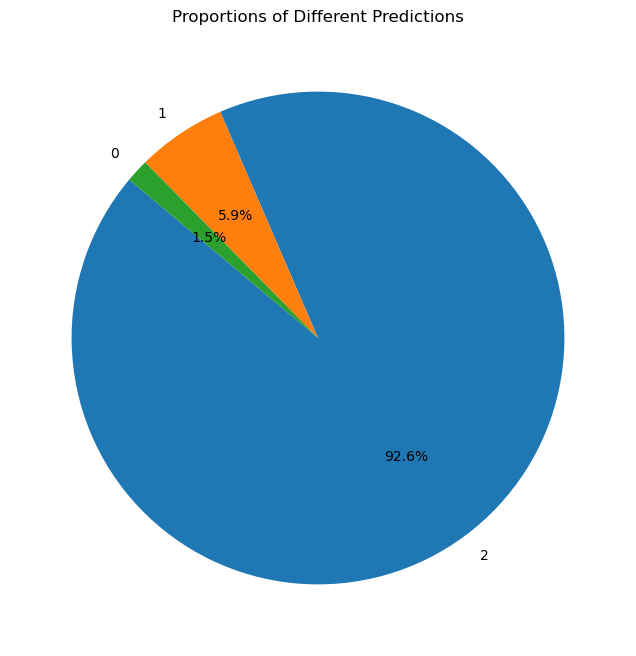

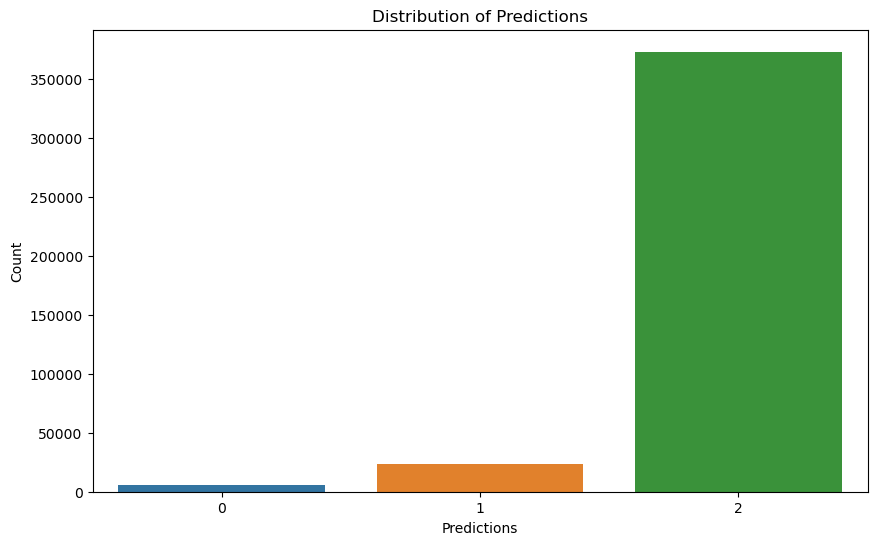

In [32]:
import pandas as pd

# Assuming 'attr' is your DataFrame and 'Predictions' is the column with model predictions
prediction_counts = attr['Predictions'].value_counts()
print(prediction_counts)
import matplotlib.pyplot as plt

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Different Predictions')
plt.show()
# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=prediction_counts.index, y=prediction_counts.values)
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.title('Distribution of Predictions')
plt.show()



2    373865
1     21464
0      7380
